In [322]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#LOF
from sklearn.neighbors import LocalOutlierFactor

from collections import Counter
from collections import defaultdict

### Schema

For detecting outliers we will not rely on just one estimator, but we will use a combination of them.<br>
In order to reduce the dimensionality of our data, we will use a PCA projection. <br>
After evaluating each anomaly estimator on our data, we will add a column to the original dataset indicating whether that row is an outlier or not.<br>
After all estimator have been tested on our data, we will take a majority voting.<br> For each row of data we will consider it an outlier if the majority of the estimator agreed on that estimate.

In [323]:
df = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
df.set_index('track_id', inplace=True)
df.drop('listens',axis=1, inplace=True)
df.drop('comments', axis=1, inplace=True)
df = df[df['genre_top'].isin(['Rock','Jazz'])]
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,405,256


In [324]:
# Data preprocessing
le = preprocessing.LabelEncoder()
df['genre_top'] = le.fit_transform(df['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = df[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [325]:
df.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'genre_top', 'duration',
       'bit_rate'],
      dtype='object')

In [326]:
columnsTitles = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'valence', 'tempo', 'duration',
       'bit_rate', 'genre_top']
df = df.reindex(columns=columnsTitles)

In [327]:
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,0
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,0
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,0
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,0
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,1


# Boxplot - IQR score

In [328]:
#function that detect outliers based on IQR 
def outlier_detector(var):
    ''' function that calculates Q1,Q3,IQR and return the number of outliers of a given variable'''
    Q1=df[var].quantile(0.25)
    Q3=df[var].quantile(0.75)
    IQR=Q3-Q1
    
    print('{}:'.format(var))
    print('Q1: {}\nQ3: {}\nIQR: {}'.format(Q1,Q3,IQR))
    
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    
    print('lower range: {}\nupper range: {}'.format(lower_whisker,upper_whisker))
    outliers = sum(df[var]<lower_whisker) + sum(df[var]>upper_whisker)
    print('{} has {} potential outliers'.format(var,outliers))
    


    #function that removes outliers
def outlier_remove(variable,u_whisker, l_whisker):
    df_clean.drop(index=df[df[variable]< l_whisker].index, inplace=True)
    df_clean.drop(index=df[df[variable]> u_whisker].index, inplace=True)
    

#### Acusticness - Danceability - Energy - Instrumentalness - Liveness - Speechiness - Valence

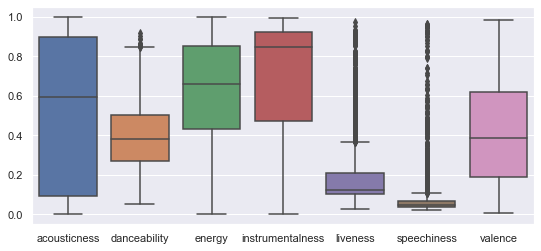

In [329]:
plt.figure(figsize=(9,4))

sns.boxplot(data=df.iloc[:,:7])
sns.set(rc={'figure.figsize':(25,8.27)})


In [330]:
for col in df.iloc[:,:7].columns:
    outlier_detector(var=col)
    print('\n')

acousticness:
Q1: 0.0943255199
Q3: 0.8984479226
IQR: 0.8041224026999999
lower range: -1.1118580841499999
upper range: 2.1046315266499995
acousticness has 0 potential outliers


danceability:
Q1: 0.2718615333
Q3: 0.5014793736
IQR: 0.22961784029999993
lower range: -0.07256522714999986
upper range: 0.8459061340499998
danceability has 11 potential outliers


energy:
Q1: 0.4328016497
Q3: 0.850100651
IQR: 0.41729900129999997
lower range: -0.19314685224999995
upper range: 1.47604915295
energy has 0 potential outliers


instrumentalness:
Q1: 0.4706153581
Q3: 0.9221123476
IQR: 0.45149698950000006
lower range: -0.2066301261500001
upper range: 1.5993578318500001
instrumentalness has 0 potential outliers


liveness:
Q1: 0.1042909085
Q3: 0.2091967113
IQR: 0.1049058028
lower range: -0.0530677957
upper range: 0.36655541550000004
liveness has 413 potential outliers


speechiness:
Q1: 0.0356185229
Q3: 0.0652800763
IQR: 0.029661553400000006
lower range: -0.008873807200000007
upper range: 0.1097724064000

#### Tempo - Bit Rate

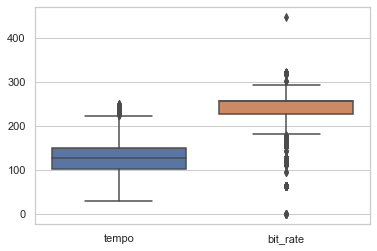

In [331]:
plt.figure(figsize=(6,4))
sns.set_style(style="whitegrid")
sns.set_color_codes()

sns.boxplot(data=df[['tempo','bit_rate']])
sns.set(rc={'figure.figsize':(15,19.27)})


In [332]:
for col in ['tempo','bit_rate']:
    outlier_detector(var=col)
    print('\n')

tempo:
Q1: 101.785
Q3: 150.287
IQR: 48.50200000000001
lower range: 29.031999999999982
upper range: 223.04000000000002
tempo has 21 potential outliers


bit_rate:
Q1: 226.0
Q3: 256.0
IQR: 30.0
lower range: 181.0
upper range: 301.0
bit_rate has 1182 potential outliers




#### duration

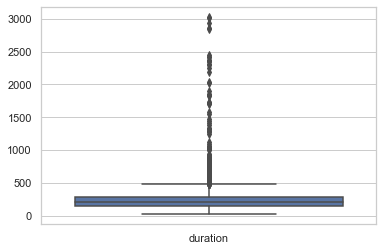

In [333]:
plt.figure(figsize=(6,4))
sns.set_style(style="whitegrid")
sns.set_color_codes()

sns.boxplot(data=df[['duration']])

In [334]:
outlier_detector(var='duration')

duration:
Q1: 147.0
Q3: 280.0
IQR: 133.0
lower range: -52.5
upper range: 479.5
duration has 226 potential outliers


# Reduce dimensionality with PCA

In [335]:
genres = df['genre_top']
df.drop('genre_top', axis=1, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
valence             0
tempo               0
duration            0
bit_rate            0
dtype: int64

In [336]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [337]:
pca = PCA(2,random_state=42)
pca.fit(scaled_df)
df_pca = pca.transform(scaled_df)
df_pca = pd.DataFrame(df_pca, columns= ['pca1', 'pca2'])
df_pca

,pca1,pca2
0,0.189876,-0.901523
1,0.161678,-0.695207
2,0.128283,-0.809803
3,0.132205,-2.232785
4,0.638167,1.938528
...,...,...
4128,1.256104,1.564099
4129,0.940031,1.637360
4130,-0.924280,-0.133727
4131,-0.563852,-0.835135


Text(0.5, 1.0, 'Data distribution in 2D')

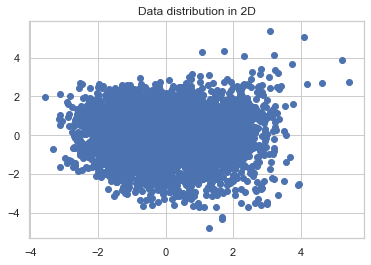

In [198]:
sns.set_style(style="whitegrid")
sns.set_color_codes()
plt.figure(figsize=(6,4))
plt.scatter(df_pca['pca1'],df_pca['pca2'])
plt.title('Data distribution in 2D')

# DBSCAN

In [199]:
from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(eps= .2, metric='euclidean', min_samples=6, n_jobs=-1)

clusters= outlier_detection.fit_predict(df_pca)
#clusters= outlier_detection.fit_predict(scaled_df)

In [200]:
# add column with outliers label
df['outlier_DBSCAN'] = clusters
df['outlier_DBSCAN'] = df['outlier_DBSCAN'].apply(lambda x: 'outlier' if x==-1 else 'inlier')

Text(0.5, 1.0, 'Anomaly Score - DBSCAN')

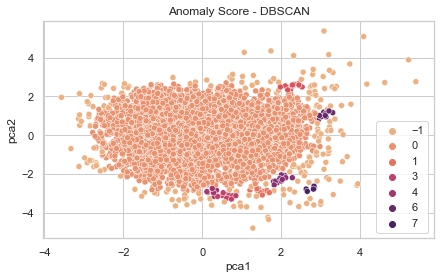

In [201]:
from matplotlib import cm
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=clusters, palette='flare')
plt.title('Anomaly Score - DBSCAN')

In [202]:
# outlier detected
df[df['outlier_DBSCAN'] =='outlier']['outlier_DBSCAN'].value_counts()

outlier    202
Name: outlier_DBSCAN, dtype: int64

# LOF

In [203]:
from sklearn.neighbors import LocalOutlierFactor

In [204]:
clf = LocalOutlierFactor(n_neighbors=50, contamination=0.1)
outliers = clf.fit_predict(scaled_df) #use scaled_df for fully dimensional dataset

In [205]:
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [206]:
# adding scores to df 
df['outlier_LOF'] = outliers
df['outlier_LOF'] = df['outlier_LOF'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [207]:
df[['outlier_LOF']].value_counts()

outlier_LOF
inlier         3719
outlier         414
dtype: int64

In this implementation of LOF **outliers** have a score close to **-1**, whereas **inlier** have a score close to **+1**.

In [208]:
clf.negative_outlier_factor_

array([-1.06433638, -1.00993767, -1.08305552, ..., -1.20866373,
       -1.15974284, -1.08693586])

In [209]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 414, 3719]))

### Inspecting outlier scores

In [210]:
np.where(outliers==-1)

(array([   6,   12,   17,   29,   37,   51,   56,   66,   68,   71,   74,
          79,   89,   91,  121,  122,  131,  139,  140,  150,  160,  189,
         200,  201,  222,  233,  265,  272,  300,  308,  311,  316,  329,
         332,  338,  351,  370,  374,  386,  405,  406,  407,  410,  420,
         421,  424,  434,  438,  452,  465,  470,  479,  482,  498,  507,
         521,  542,  544,  546,  586,  599,  600,  604,  607,  629,  631,
         673,  674,  675,  692,  698,  699,  708,  711,  712,  713,  725,
         726,  735,  743,  753,  759,  785,  787,  788,  790,  800,  809,
         810,  831,  857,  872,  876,  878,  893,  901,  914,  915,  931,
         942,  943,  951,  952,  957,  962,  967,  978,  983,  986,  988,
         989, 1019, 1036, 1042, 1074, 1082, 1085, 1101, 1106, 1116, 1130,
        1131, 1132, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1150,
        1154, 1174, 1186, 1187, 1224, 1241, 1258, 1266, 1301, 1306, 1309,
        1316, 1322, 1329, 1332, 1333, 

In [211]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.47338706, -1.55912185, -1.37712321, -1.34526711, -1.28857765,
       -1.28449938, -1.34292205, -1.37715871, -1.30362119, -1.30656266,
       -1.37582909, -1.29718183, -1.28665382, -1.36444943, -1.44014002,
       -1.42297436, -1.28965474, -1.26218461, -1.26839184, -1.40167907,
       -1.68617446, -1.68453504, -1.84421968, -1.25491113, -1.29613524,
       -1.44696425, -1.37059737, -1.36966551, -1.28983819, -1.45819036,
       -1.26955532, -1.43942625, -1.74431081, -1.45223497, -1.31797863,
       -1.29249331, -1.26849865, -1.32652856, -1.3639167 , -1.28151983,
       -1.66993458, -1.36337144, -1.23785674, -1.34162076, -1.43032473,
       -1.26409334, -1.29997426, -1.3046981 , -1.63564504, -1.263257  ,
       -1.32577596, -1.33674378, -1.26898799, -1.54669571, -1.22918425,
       -1.30933775, -1.33795541, -1.23538094, -1.39221574, -1.22874818,
       -1.41966096, -1.31191327, -1.32114168, -1.4224782 , -1.24841742,
       -1.37853427, -1.49626325, -1.25304591, -1.52419788, -1.46

In [212]:
# maximum outlier score
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.2280218367671614

In [213]:
# minimum outlier score
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.9512893321525309

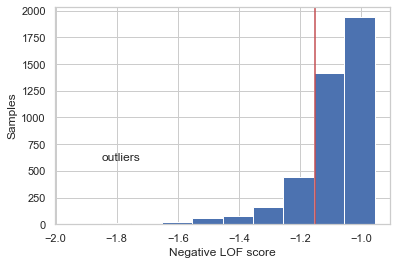

In [214]:
plt.figure(figsize=(6,4))
plt.hist(clf.negative_outlier_factor_, bins=10)
plt.axvline(-1.15, c='r')
plt.text(-1.85, 600, 'outliers')
plt.ylabel('Samples')
plt.xlabel('Negative LOF score')
plt.show()

Text(0.5, 1.0, 'Anomaly Score - LOF')

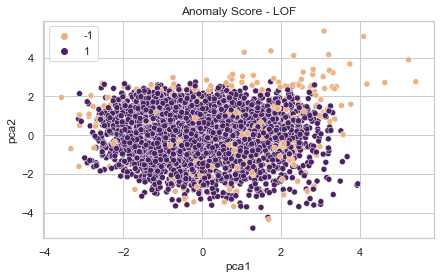

In [215]:
sns.set_style(style="whitegrid")
sns.set_color_codes()

plt.figure(figsize=(7,4))

cmap= cm.get_cmap('Set1')
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')
plt.title('Anomaly Score - LOF')

# KNN 

In [216]:
from pyod.models.knn import KNN

In [217]:
help(KNN)

Help on class KNN in module pyod.models.knn:

class KNN(pyod.models.base.BaseDetector)
 |  KNN(contamination=0.1, n_neighbors=5, method='largest', radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=1, **kwargs)
 |  
 |  kNN class for outlier detection.
 |  For an observation, its distance to its kth nearest neighbor could be
 |  viewed as the outlying score. It could be viewed as a way to measure
 |  the density. See :cite:`ramaswamy2000efficient,angiulli2002fast` for
 |  details.
 |  
 |  Three kNN detectors are supported:
 |  largest: use the distance to the kth neighbor as the outlier score
 |  mean: use the average of all k neighbors as the outlier score
 |  median: use the median of the distance to k neighbors as the outlier score
 |  
 |  Parameters
 |  ----------
 |  contamination : float in (0., 0.5), optional (default=0.1)
 |      The amount of contamination of the data set,
 |      i.e. the proportion of outliers in the data set. U

In [218]:
clf = KNN(n_neighbors=50)
clf.fit(scaled_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=50, p=2,
  radius=1.0)

In [219]:
clf.decision_scores_

array([1.53234446, 1.50961496, 1.74844886, ..., 2.42147917, 2.21296917,
       2.15615847])

In [220]:
anomlay_score = clf.decision_function(scaled_df)

In [221]:
outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([3727,  406]))

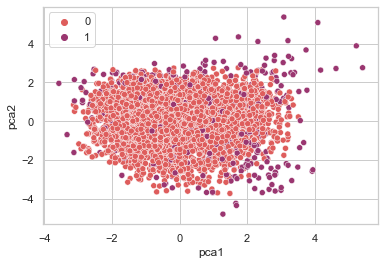

In [222]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')

In [223]:
df['outlier_KNN'] = outliers 
df['outlier_KNN'] = df['outlier_KNN'].apply(lambda x: 'inlier' if x==0 else 'outlier')

In [224]:
df['outlier_KNN'].value_counts()

inlier     3727
outlier     406
Name: outlier_KNN, dtype: int64

# ABOD

In [225]:
#pip install pyod

In [226]:
from pyod.models.abod import ABOD

In [227]:
clf = ABOD(n_neighbors=50)
clf.fit(scaled_df)

ABOD(contamination=0.1, method='fast', n_neighbors=50)

In [228]:
clf.decision_scores_

array([-0.03131584, -0.03768221, -0.02407713, ..., -0.00366651,
       -0.00558754, -0.00729451])

In [229]:
outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([3723,  410]))

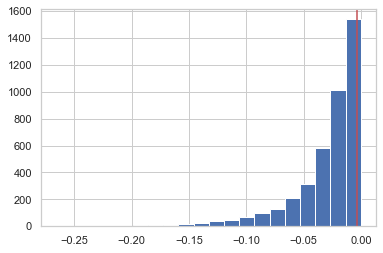

In [230]:
plt.figure(figsize=(6,4))
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='r')
plt.show()

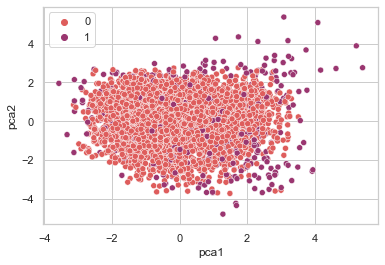

In [231]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=outliers, palette='flare')

In [232]:
# save outlier scores to df
df['outlier_ABOD'] = outliers 
df['outlier_ABOD'] = df['outlier_ABOD'].apply(lambda x: 'inlier' if x==0 else 'outlier')

In [233]:
df['outlier_ABOD'].value_counts()

inlier     3723
outlier     410
Name: outlier_ABOD, dtype: int64

# Isolation Forest & Extended Isolation Forest

In [234]:
#pip install eif

In [235]:
import eif as iso
sns.set_style(style="whitegrid")
sns.set_color_codes()

F0 is the standard Isolation Forest, which corresponds to extension level 0 in the context of EIF. F1 is the Extended Isolation Forest with extension 1, which in the case of 2_D data (as in here), is the fully extended case.

In [236]:
# transform data in an np.ndarray 
X = np.array(df_pca)
X_fd= np.array(scaled_df)  #no dim reduction

### Train Forest

**ntree** = number of trees to be used in fitting the forest<br>
**sample_size** = number of rows to be sub-sampled in creating each tree. This must be less than the number of observations in the dataset

In [237]:
# PCA REDUCTION FORESTS
F0  = iso.iForest(X, ntrees=600, sample_size=100, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X, ntrees=600, sample_size=100, ExtensionLevel=1)

# FULL DIMENSIONALITY FORESTS
F0_fd =iso.iForest(X_fd, ntrees=600, sample_size=100, ExtensionLevel=0)
F1_fd  = iso.iForest(X_fd, ntrees=600, sample_size=100, ExtensionLevel=1)


In [238]:
xxx = np.array([[0,0.]])
SL0 = F0.compute_paths_single_tree(xxx, 0)

In [239]:
SL0[0]

7.1544313297999995

In [240]:
F0.limit

7

### Score Data 

In [241]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 

# PCA reduction
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

# full dimensionality
S0_fd = F0_fd.compute_paths(X_in=X_fd)
S1_fd = F1_fd.compute_paths(X_in=X_fd)

In [242]:
# PCA reduction
df['outlier_IF-PCA'] = S0
df['outlier_IF-PCA'] = df['outlier_IF-PCA'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')
df['outlier_EIF-PCA'] = S1
df['outlier_EIF-PCA'] = df['outlier_EIF-PCA'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')

In [243]:
df['outlier_IF'] = S0_fd
df['outlier_IF'] = df['outlier_IF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')
df['outlier_EIF'] = S1_fd
df['outlier_EIF'] = df['outlier_EIF'].apply(lambda x: 'inlier' if x<=0.6 else 'outlier')

In [244]:
# pca EIF
df['outlier_EIF-PCA'].value_counts()

inlier     3982
outlier     151
Name: outlier_EIF-PCA, dtype: int64

In [245]:
# pca IF
df['outlier_IF-PCA'].value_counts()

inlier     3913
outlier     220
Name: outlier_IF-PCA, dtype: int64

In [246]:
# full dim EIF
df['outlier_EIF'].value_counts()

inlier     4073
outlier      60
Name: outlier_EIF, dtype: int64

In [247]:
# full dim IF
df['outlier_IF'].value_counts()

inlier     4089
outlier      44
Name: outlier_IF, dtype: int64

### Plot anomaly scores

Text(0.5, 1.0, 'Extended Isolation Tree')

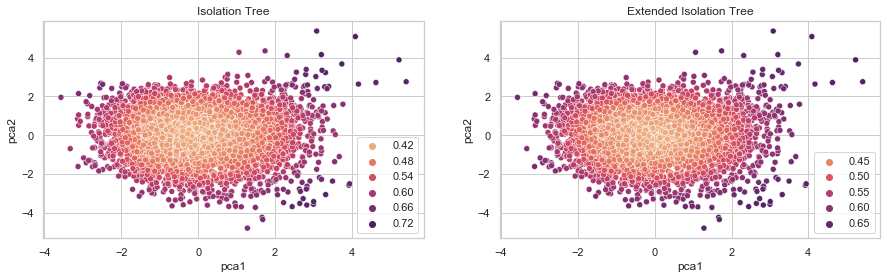

In [248]:
#
f = plt.figure(figsize=(15,4))

ax1 = f.add_subplot(121)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S0,palette='flare')
plt.title('Isolation Tree')

ax2 = f.add_subplot(122)
sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue=S1,palette='flare')
plt.title('Extended Isolation Tree')


### Anomaly Score Distribution 

Anomaly are scores with a value betwee 0 and 1.<br>
The higher the score the more likely the observation is an outlier.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


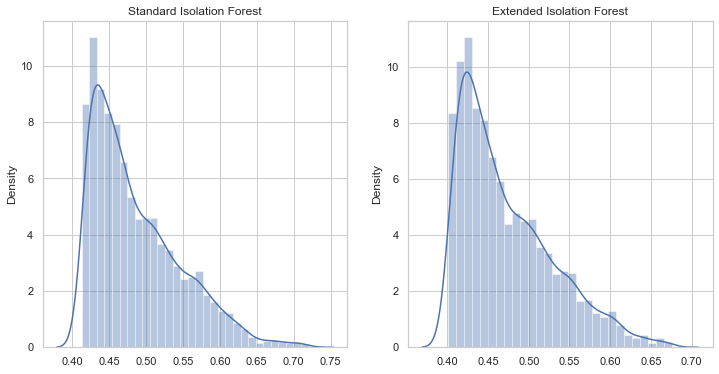

In [249]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(S0, kde=True, color="b")
plt.title('Standard Isolation Forest')

plt.subplot(1,2,2)
sns.distplot(S1, kde=True, color="b")
plt.title('Extended Isolation Forest')
plt.show()

### Anomaly Score Map

In [250]:
xx, yy = np.meshgrid(np.linspace(-5., 6., 20), np.linspace(-5., 6, 20))

S0_ = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0_ = S0_.reshape(xx.shape)

S1_ = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1_ = S1_.reshape(xx.shape)

In [251]:
S0_.shape

(20, 20)

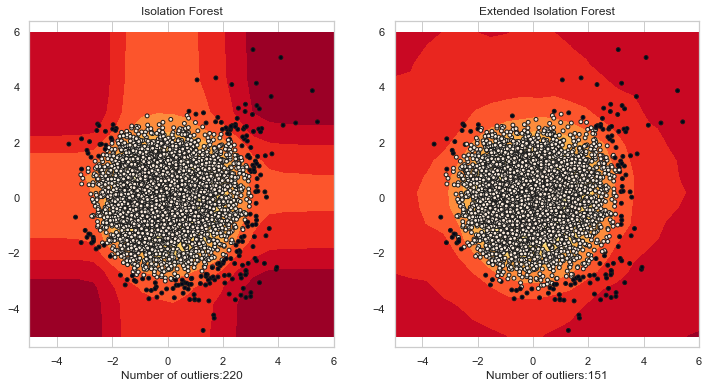

In [252]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0_),np.max(S0_),10)
CS = ax1.contourf(xx, yy, S0_, levels, cmap=plt.cm.YlOrRd)
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=df['outlier_IF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Isolation Forest')
plt.xlabel(f"Number of outliers:{df['outlier_IF-PCA'].value_counts()[1]}")



ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1_),np.max(S0_),10)
CS = ax2.contourf(xx, yy, S1_, levels, cmap=plt.cm.YlOrRd)
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15,c=df['outlier_EIF-PCA'].apply(lambda x: 0 if x=='inlier' else -1),edgecolors='k')
plt.axis("equal")
plt.title('Extended Isolation Forest')
plt.xlabel(f"Number of outliers:{df['outlier_EIF-PCA'].value_counts()[1]}")

plt.show()

** Legend **<br>
white points** = inliers<br>
**balck point** = outliers<br>
**score threshold** = 0.6

## Auto Encoder (optional) 

In [253]:
#help(AutoEncoder)

In [254]:
from pyod.models.auto_encoder import AutoEncoder

In [255]:
scaled_df.shape

(4133, 10)

In [256]:
scaled_df

array([[ 1.02985274,  0.31691984,  0.07801309, ...,  0.02693708,
        -0.74576189,  0.19265136],
       [-0.75595289,  0.28577395, -0.51298494, ..., -0.20549598,
         0.36763498,  0.19265136],
       [ 0.03025499,  0.15425321, -0.55639444, ...,  0.23488772,
         0.49540183,  0.19265136],
       ...,
       [-1.32137482,  1.53890309,  1.2777149 , ..., -0.07930346,
        -0.07042281,  1.39291979],
       [-1.29503999,  1.73814459,  1.32968483, ..., -0.97729256,
        -0.13886933,  1.39291979],
       [-1.3662832 , -0.77481062,  0.93070439, ..., -1.31689625,
        -0.10692762,  1.39291979]])

In [257]:
clf = AutoEncoder(hidden_neurons=[10, 5, 10], #under-complete autoencoder
                  hidden_activation='tanh',
                  output_activation='tanh', # tanh because the inputs are 
                  epochs=100,
                  validation_size= 0.3)

In [258]:
clf.fit(scaled_df)

outliers = clf.predict(scaled_df)
np.unique(outliers, return_counts=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

Epoch 65/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8518 - val_loss: 0.7833
Epoch 66/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8525 - val_loss: 0.7743
Epoch 67/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8526 - val_loss: 0.7741
Epoch 68/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8522 - val_loss: 0.7740
Epoch 69/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8542 - val_loss: 0.7791
Epoch 70/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8520 - val_loss: 0.7737
Epoch 71/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8525 - val_loss: 0.7728
Epoch 72/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8512 - val_loss: 0.7726
Epoch 73/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8547 - val_loss: 0.7711
Epoch 74/100
91/91 [==============================] - 0s 2ms/step - loss: 0.8507 - val_loss: 0.7757


(array([0, 1]), array([3719,  414]))

In [259]:
df['outlier_AutoEncoder'] = outliers
df['outlier_AutoEncoder'] = df['outlier_AutoEncoder'].apply(lambda x: 'inlier' if x==0 else 'outlier')

## Removing Outliers

Algorithms employed:
1. DBSCAN
2. KNN
3. LOF
4. ABOD
5. Isolation Forest
6. Extended Isolation Forest
7. Autoencoder

Based on the scores provided by each outlier detection method, we will take a majority voting in order to determine if a point x is an outlier or an inlier.

In [260]:
# majority voting
mostCommonVote=[]
for row in df[['outlier_DBSCAN', 'outlier_LOF', 'outlier_ABOD','outlier_IF',
       'outlier_EIF','outlier_KNN','outlier_AutoEncoder']].values:
    votes, values = np.unique(row, return_counts=True)
    if np.all(values<=1):
            mostCommonVote.append( row[0] )
    else:
        mostCommonVote.append( votes[np.argmax(values)] )

df['Winner'] = mostCommonVote

In [261]:
df[['Winner']].value_counts()

Winner 
inlier     3869
outlier     264
dtype: int64

In [262]:
df[df['Winner']=='inlier']

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,outlier_DBSCAN,outlier_LOF,outlier_KNN,outlier_ABOD,outlier_IF-PCA,outlier_EIF-PCA,outlier_IF,outlier_EIF,outlier_AutoEncoder,Winner
track_id,,,,,,,,,,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123823,0.303772,0.227905,0.207037,0.664426,0.129962,0.036349,0.031072,99.323,425,255,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
123824,0.497877,0.328307,0.604455,0.909813,0.127005,0.040391,0.037689,101.553,526,262,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier
124184,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,0.143388,124.996,230,320,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier,inlier


In [263]:
df[df['Winner']=='outlier'].index

Int64Index([   155,    174,    175,    179,    311,    325,    333,    347,
               351,    394,
            ...
             75208,  86127,  91049,  94550, 104073, 104693, 105958, 111210,
            111213, 116541],
           dtype='int64', name='track_id', length=264)

In [276]:
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/genre_labels.csv')
labels.set_index('track_id',inplace=True)
df = df.merge(labels, on='track_id')
df.set_index('track_id',inplace=True)

In [294]:
columns = df.iloc[:,:10].columns

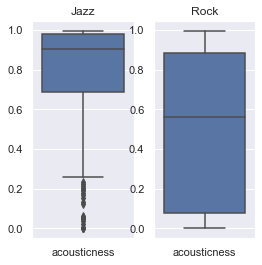

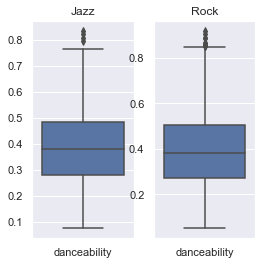

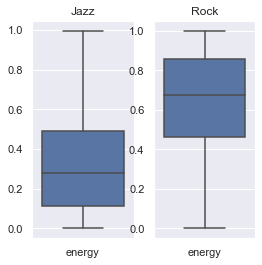

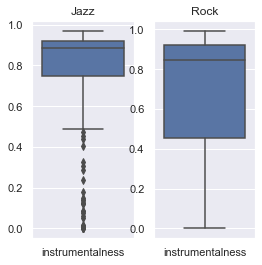

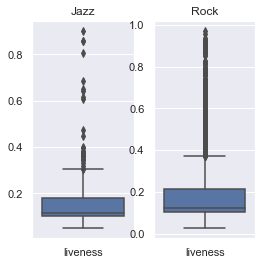

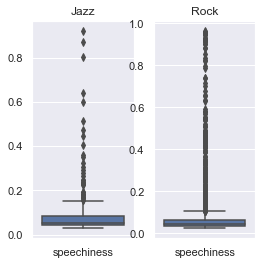

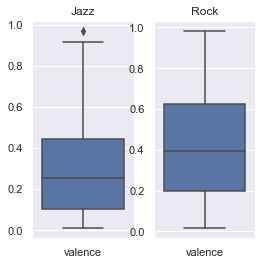

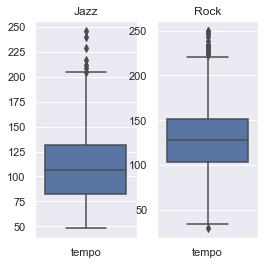

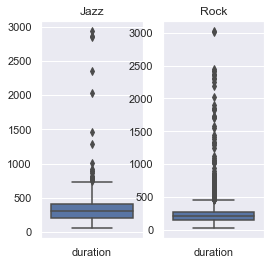

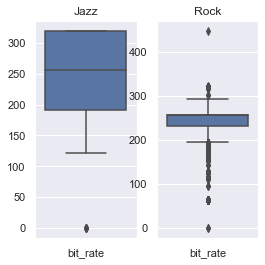

In [303]:
for col in columns:
    

    plt.figure(figsize=(4,4))
    plt.subplot(1,2,1)
    plt.title('Jazz')
    sns.boxplot(data=df[df['genre_top']=='Jazz'][[col]])
    sns.set(rc={'figure.figsize':(25,8.27)})
   

    plt.subplot(1,2,2)
    plt.title('Rock')
    sns.boxplot(data=df[df['genre_top']=='Rock'][[col]])
    sns.set(rc={'figure.figsize':(25,8.27)})
    

In [304]:
df = df.drop(index=df[df['Winner']=='outlier'].index, axis=0)

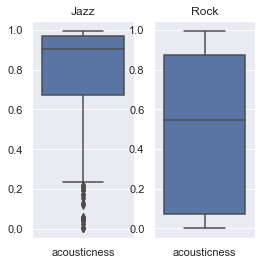

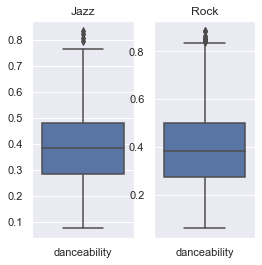

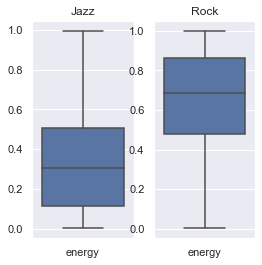

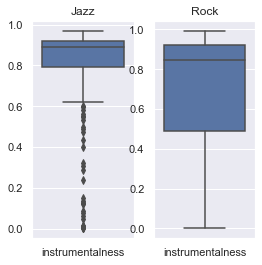

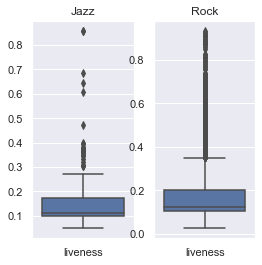

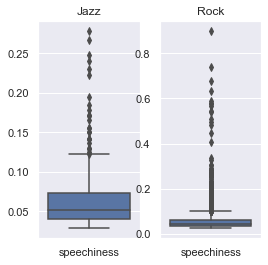

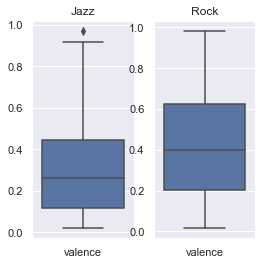

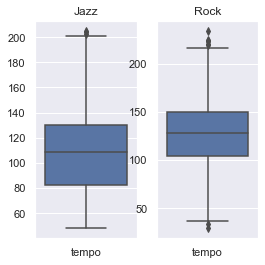

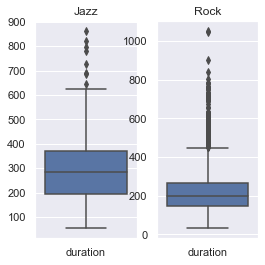

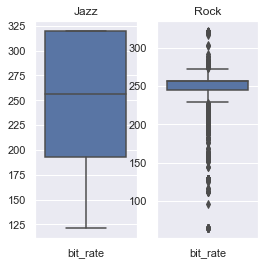

In [305]:
for col in columns:
    

    plt.figure(figsize=(4,4))
    plt.subplot(1,2,1)
    plt.title('Jazz')
    sns.boxplot(data=df[df['genre_top']=='Jazz'][[col]])
    sns.set(rc={'figure.figsize':(25,8.27)})
   

    plt.subplot(1,2,2)
    plt.title('Rock')
    sns.boxplot(data=df[df['genre_top']=='Rock'][[col]])
    sns.set(rc={'figure.figsize':(25,8.27)})
    

In [306]:
df.iloc[:,:10]

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate
track_id,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256
...,...,...,...,...,...,...,...,...,...,...
123823,0.303772,0.227905,0.207037,0.664426,0.129962,0.036349,0.031072,99.323,425,255
123824,0.497877,0.328307,0.604455,0.909813,0.127005,0.040391,0.037689,101.553,526,262
124184,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,0.143388,124.996,230,320


In [307]:
scaled_clean= scaler.fit_transform(df.iloc[:,:10])

In [308]:
pca = PCA(2,random_state=42)
pca.fit(scaled_clean)
df_clean = pca.transform(scaled_clean)
df_clean = pd.DataFrame(df_clean, columns= ['pca1', 'pca2'])

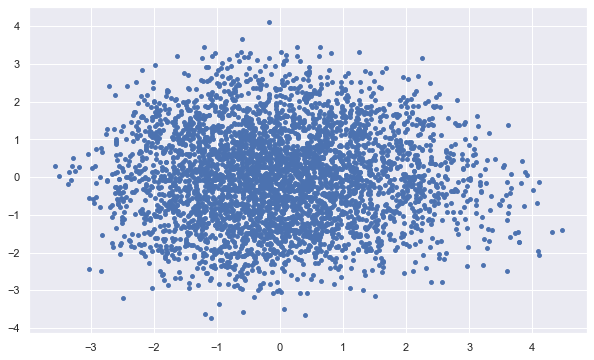

In [313]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean['pca1'],df_clean['pca2'],s=15)

In [320]:
df_clean.iloc[144]

pca1    1.254316
pca2    0.572990
Name: 144, dtype: float64

In [311]:
df.iloc[19]

acousticness           0.979755
danceability           0.371784
energy                 0.523408
instrumentalness       0.968838
liveness               0.109447
speechiness            0.070379
valence                 0.37717
tempo                   168.606
duration                    125
bit_rate                    256
outlier_DBSCAN           inlier
outlier_LOF              inlier
outlier_KNN              inlier
outlier_ABOD             inlier
outlier_IF-PCA           inlier
outlier_EIF-PCA          inlier
outlier_IF               inlier
outlier_EIF              inlier
outlier_AutoEncoder      inlier
Winner                   inlier
genre_top_x                Rock
genre_top_y                Rock
genre_top                  Rock
Name: 249, dtype: object

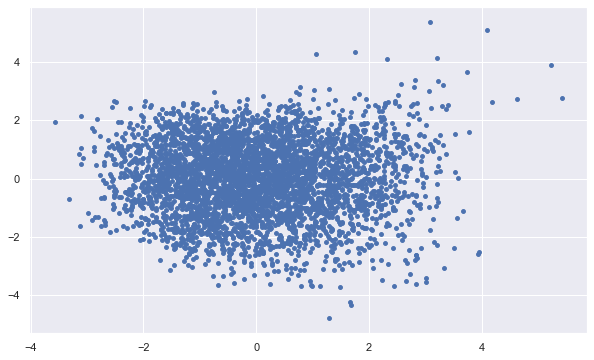

In [315]:
plt.figure(figsize=(10,6))
plt.scatter(df_pca['pca1'],df_pca['pca2'],s=15)

In [ ]:
df[df['outlier_AutoEncoder']=='outlier']

In [317]:
print(columns)

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'valence', 'tempo', 'duration', 'bit_rate'],
      dtype='object')


In [319]:
df = df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'valence', 'tempo', 'duration', 'bit_rate', 'genre_top']]
df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251,128.537,82,256,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,Rock
...,...,...,...,...,...,...,...,...,...,...,...
123823,0.303772,0.227905,0.207037,0.664426,0.129962,0.036349,0.031072,99.323,425,255,Rock
123824,0.497877,0.328307,0.604455,0.909813,0.127005,0.040391,0.037689,101.553,526,262,Rock
124184,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,0.143388,124.996,230,320,Rock


In [321]:
with open("echo_audiofeatures_outlierfree.csv","w") as new_df:
    new_df.write(df.to_csv(index=True))